In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import Binarizer, MultiLabelBinarizer
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

In [2]:
import actigamma as ag

In [3]:
# generate a dataset based on 100 bins from 0 to 2 MeV
MINENERGY = 0.0
MAXENERGY = 4e6
NBINS = 200
SPECTYPE = "gamma"

# setup the DB
db = ag.Decay2012Database()
grid = ag.EnergyGrid(bounds=ag.linspace(MINENERGY, MAXENERGY, NBINS+1))

In [4]:
class RandomLineAggregator(ag.LineAggregator):
    """
        Randomly vary the line energies by their uncertainty

        TODO: randomly remove lines with low intensity or related to their intensity
    """
    def _findlines(self, inventory: ag.UnstablesInventory, *args, spectype: str="gamma", **kwargs):
        lines = []
        values = []

        nrofsigma = 1
        if 'nrofsigma' in kwargs:
            nrofsigma = kwargs['nrofsigma']

        for zai, activity in inventory:
            name = self.db.getname(zai)
            # check it exists in database
            if name not in self.db:
                raise ag.UnknownOrUnstableNuclideException(
                    "{} not in database - maybe too exotic or is it stable?".format(zai))

            # check that data exists for that decay type
            if spectype not in self.db.gettypes(name):
                raise ag.NoDataException(
                    "{} does not have {} decay mode".format(name, spectype))

            energies = self.db.getenergies(name, spectype=spectype)
            energyunc = self.db.getenergiesunc(name, spectype=spectype)
            intensities = self.db.getintensities(name, spectype=spectype)*activity

            newenergies = []
            for emean, eunc in zip(energies, energyunc):
                newenergies.append(np.random.normal(emean, eunc*nrofsigma))
            lines.extend(np.array(newenergies))
            values.extend(intensities)

        return lines, values

In [5]:
# just take 10 nuclides at random
allradionuclides = db.allnuclidesoftype(spectype=SPECTYPE)
radionuclides = allradionuclides
random.shuffle(allradionuclides)
print(len(allradionuclides))

1750


In [6]:
# create a line aggregator based on randomly varying the line energy
lc = RandomLineAggregator(db, grid)

In [7]:
def get_random_inventory(maxnuclides=5):
    # randomly pick between 1 and maxnuclides to generate data
    nrofnuclides = random.randrange(1, maxnuclides+1)
    # pick nrofnuclides - must be unique 
    nuclides = []
    indices = []
    while len(nuclides) < nrofnuclides:
        indx = random.randrange(maxnuclides)
        nuclide = allradionuclides[indx]
        if nuclide not in nuclides:
            nuclides.append(nuclide)
            indices.append(indx)

    # random activity between 1e18 and 1e21 atoms
    inv = ag.UnstablesInventory(data=[(db.getzai(n),
        ag.activity_from_atoms(db, n, np.random.uniform(low=1e18, high=1e21))) \
            for n in nuclides])
    hist, _ = lc(inv, spectype=SPECTYPE, nrofsigma=3)
    return hist, indices, inv,

In [8]:
def plot_inventory(hist, inv=None, newfig=True, colour='k', logy=True, **kwargs):
    X, Y = ag.getplotvalues(grid.bounds, hist)
    if newfig:
        fig = plt.figure(figsize=(12,7))
    plt.plot(X, Y, colour)
    plt.xlabel("Energy ({})".format(grid.units), fontsize=18)
    plt.ylabel("{} per unit time (s-1)".format(SPECTYPE), fontsize=18)
    if logy:
        plt.yscale('log')
#     plt.show()
    if inv:
        print([db.getname(zai) for zai in inv.zais])
        print([act for act in inv.activities])

['Rn221', 'I134', 'Hg197m', 'Mo105', 'Ar35']
[1.5181028617948995e+17, 1.7406162249871696e+17, 1500580040784597.2, 1.6366929561438765e+19, 1.542545718269582e+20]


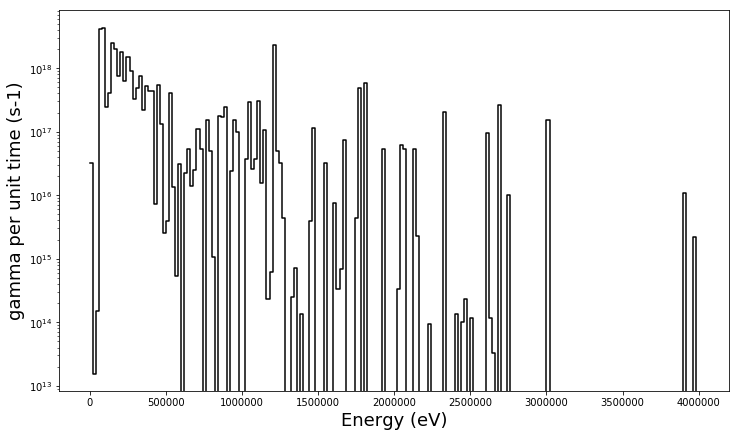

In [9]:
hist, _, inv = get_random_inventory()
plot_inventory(hist, inv)

In [10]:
# make a dataset based on randomly generated variations of sample data
NSAMPLES = 1000
datasetX, datasetY = [], []
for _ in range(NSAMPLES):
    hist, indices, _ = get_random_inventory(maxnuclides=5)
    datasetX.append(np.array(hist))
    datasetY.append(indices)

In [11]:
# let's look at scaling
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
    
# fig, ax1 = plt.subplots(figsize=(12,7))
        
# X, Y = ag.getplotvalues(grid.bounds, datasetX[0])
# ax1.plot(X, Y, 'k')
# ax1.set_xlabel("Energy ({})".format(grid.units), fontsize=18)
# ax1.set_ylabel("{} per unit time (s-1)".format(SPECTYPE), fontsize=18)
# ax1.set_yscale('log')

# # convert to log values then min max scale
# data_min = np.nanmin(datasetX, axis=1)
# data_max = np.nanmax(datasetX, axis=1)
# for i, data in enumerate(datasetX):
#     datasetX[i] = (np.log(data+1) - data_min[i]) / (math.log(data_max[i]) - data_min[i])
# # we need to scale values from log to [0,1] -> how best to do this?
# # datasetX = MinMaxScaler().fit_transform(datasetX)

# ax2 = ax1.twinx()
# ax2.set_ylabel("Scaled")
# X, Y = ag.getplotvalues(grid.bounds, datasetX[0])
# ax2.plot(X, Y, 'r')

In [12]:
# ignore scaling altogether and just have binary values (0=no lines, 1=lines present in bin)
datasetX = Binarizer().transform(datasetX)
datasetY = MultiLabelBinarizer().fit_transform(datasetY)

In [13]:
X_train, X_test, y_train, y_test = \
    train_test_split(datasetX, datasetY, test_size=.4, random_state=42)

In [14]:
y_train

array([[1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       ...,
       [0, 1, 1, 1, 0],
       [0, 0, 0, 1, 1],
       [1, 0, 0, 1, 1]])

In [15]:
classifier = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, max_features='auto', verbose=False))

In [16]:
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)
print(score)

0.6825


In [17]:
# plot + predict
def plot_and_predict(indices):
    testnuclides = [radionuclides[i] for i in indices]
    inv = ag.UnstablesInventory(data=[(db.getzai(n), 
                                       ag.activity_from_atoms(db, 
                                                              n, 
                                                              np.random.uniform(low=1e18, high=1e21))) 
                                      for n in testnuclides])

    lc = ag.LineAggregator(db, grid)
    hist, _ = lc(inv, spectype=SPECTYPE)
    prediction = classifier.predict([[1 if bin > 0 else 0 for bin in hist ]])
    print([i for i, n in enumerate(prediction[0]) if n > 0])
    plot_inventory(hist)

[1]


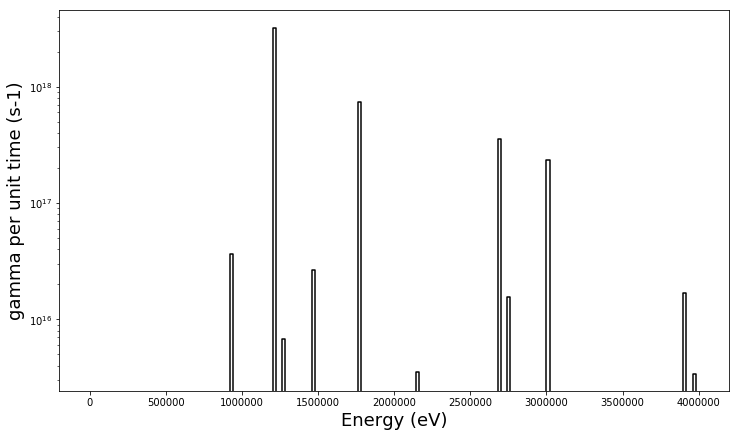

In [18]:
plot_and_predict([1])

[0, 1, 2]


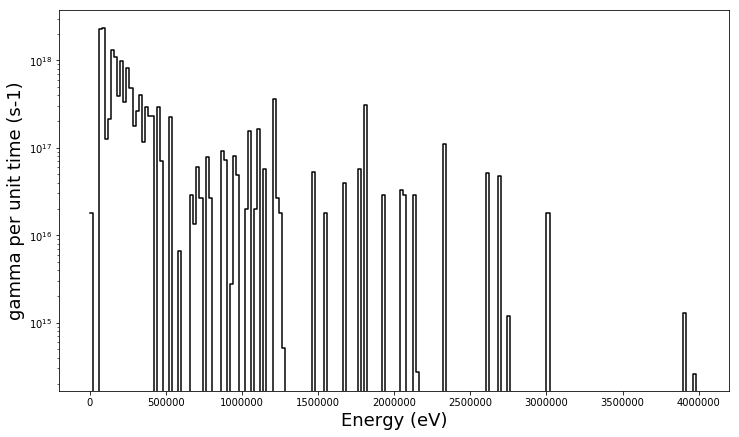

In [19]:
plot_and_predict([0, 1, 2])